# Making maps with cartopy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

import cartopy.crs as ccrs
import xroms

In [2]:
# Initiate the Dataset
A = xroms.roms_dataset("ocean_avg_0014.nc")
H = A.h.where(A.mask_rho > 0)

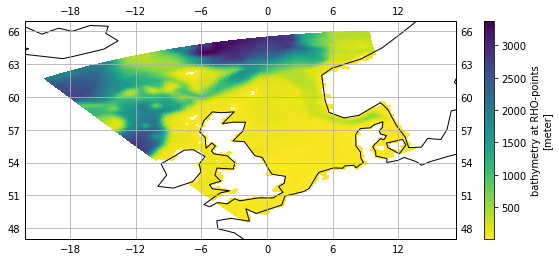

In [3]:
# Minimal cartopy example, lon-lat projection
plt.figure(figsize=(10, 4))
ax = plt.subplot(projection=ccrs.PlateCarree());

H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, infer_intervals=True, cmap='viridis_r')
ax.coastlines()
ax.gridlines(draw_labels=True);

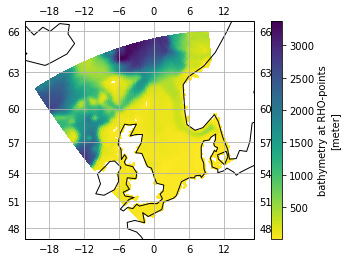

In [4]:
# Mercator
plt.figure()
lonlat = ccrs.PlateCarree()
proj = ccrs.Mercator()
ax = plt.subplot(projection=proj)

H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, transform=lonlat, 
                  infer_intervals=True, cmap='viridis_r')
ax.coastlines()
ax.gridlines(draw_labels=True);

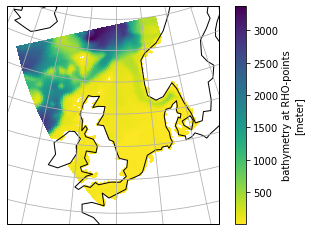

In [5]:
# Polar stereographic
plt.figure()
lonlat = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()
ax = plt.subplot(projection=proj)

H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, transform=lonlat, 
                  infer_intervals=True, cmap='viridis_r')
ax.coastlines()
ax.gridlines()   # Labels does not work

The above coastline is to coarse at this regional scale and will be totally useless at finer scales. The GSHHS family of coastlines are available in cartopy. This is done by the line

```python
ax.add_feature(cfeature.GSHHSFeature(scale='i'), facecolor='Khaki')
```
However, this is slow. An example is given in the code below. 

The reason it is slow is that in handles the global data set. [henter det data fra nettet også?]. The solution is to make a local feature, store it in a file, and reuse that.

```python
import cartopy.feature as cfeature
plt.figure()
lonlat = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()
ax = plt.subplot(projection=proj)

# --- Add land feature
ax.add_feature(cfeature.GSHHSFeature(scale='i'), facecolor='Khaki')

H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, transform=lonlat, 
                  infer_intervals=True, cmap='viridis_r')

ax.coastlines()
ax.gridlines() 
```

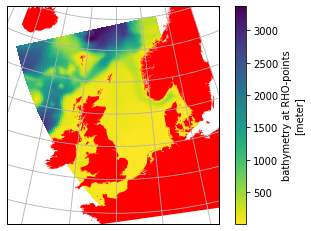

In [6]:
# Make coastline if necessary, and test it
import os.path
import shapely.wkb as wkb
#import shapely.geometry as geom
import cartopy.feature as cfeature

coastfile = 'coast.wkb'

# Make the coast file if needed

if not os.path.exists(coastfile):
    from coast2wkb import coast2wkb
    coast2wkb(-22, 18, 47, 67, 'i', coastfile)

# Check that the coast file is correct
plt.figure()
lonlat = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()
ax = plt.subplot(projection=proj)

# Read the WKB file into a cartopy feature
with open(coastfile, mode='rb') as fp:
    mpoly = wkb.load(fp)
rfeat = cfeature.ShapelyFeature(mpoly, crs=lonlat, facecolor='Red')
ax.add_feature(rfeat)

H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, transform=lonlat, 
                  infer_intervals=True, cmap='viridis_r')

ax.gridlines();

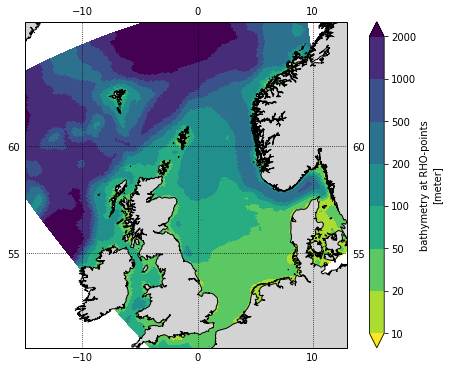

In [7]:
# Coastal file 
coastfile = 'coast.wkb'

# Geographic limitations
lon0, lon1 = -15, 13
lat0, lat1 = 50, 65

depth_levels = [10, 20, 50, 100, 200, 500, 1000, 2000]

# Define map projection
lonlat = ccrs.PlateCarree()
proj = ccrs.Mercator()
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)
ax.set_extent([lon0, lon1, lat0, lat1], lonlat)


# Plot the bottom topography
H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, transform=lonlat, levels=depth_levels,
                  infer_intervals=True, cmap='viridis_r')

# Plot land
with open(coastfile, mode='rb') as fp:
    mpoly = wkb.load(fp)
rfeat = cfeature.ShapelyFeature(mpoly, crs=lonlat,
                                facecolor='LightGrey', edgecolor='Black')
ax.add_feature(rfeat)
    
# Add graticule
ax.gridlines(xlocs=np.arange(-20, 30, 10), ylocs=np.arange(50, 70, 5),
             color='black', linestyle=':', draw_labels=True);


Make a nice polar stereographic plot. The coastline is GSHHS intermediate resolution
as extracted in the geography notebook. An explicit wedge-shaped boundary is created,
comment out the `ax.set_boundary` statement to compare with the usual rectangular domain.

In [8]:
# Utility function, generating a nice range of numbers
# Move somewhere else

def erange(a0, a1, da):
    i0 = int(np.floor(a0/da))     # i0*da <= a0 < (i0+1)*da
    i1 = int(1-np.ceil(-a1/da))   # (i1-1)*da <= a1 < i1*da
    return [da*i for i in range(i0, i1+1)]
    
def irange(a0, a1, da):
    # i0 = int(1-np.ceil(-a0/da))   # (i0-1)*da <= a0 < i0*da
    i0 = int(np.ceil(a0/da))        # (i0*da <= a0 < i0*da
    i1 = int(np.floor(a1/da))       # i1*da <= a1 < (i1+1)*da
    return [da*i for i in range(i0, i1+1)]
    


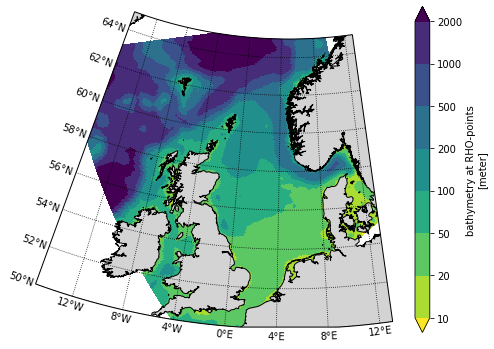

In [9]:
# Make a polar stereographic map

# Coastal file 
coastfile = 'coast.wkb'

# Geographic limitations
lonmin, lonmax = -15, 13
latmin, latmax = +50, 65
dlon, dlat = 4, 2     # step size in longitude and latitide
lon0 = 5              # Longitude of vertical meridian

#lon_grid = erange(lonmin, lonmax, dlon)
#lat_grid = erange(latmin, latmax, dlat)

depth_levels = [10, 20, 50, 100, 200, 500, 1000, 2000]

# Define map projection
lonlat = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=lon0)
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)
ax.set_extent([lonmin, lonmax, latmin, latmax], lonlat)

# Set up the wedge-shaped boundary
south = proj.transform_points(
    lonlat, np.linspace(lonmin, lonmax, 100), np.array(100*[latmax]))
north = proj.transform_points(
    lonlat, np.linspace(lonmax, lonmin, 100), np.array(100*[latmin]))
boundary = np.vstack((north[:, :2], south[:, :2]))
ax.set_boundary(Path(boundary), transform=proj)

# Plot the bottom topography
H.plot.pcolormesh('lon_rho', 'lat_rho', ax=ax, transform=lonlat, levels=depth_levels,
                  infer_intervals=True, cmap='viridis_r')

# Plot land
with open(coastfile, mode='rb') as fp:
    mpoly = wkb.load(fp)
rfeat = cfeature.ShapelyFeature(mpoly, crs=lonlat,
                                facecolor='LightGrey', edgecolor='Black')
ax.add_feature(rfeat)
    
# Add graticule  (gjør automatisk)
ax.gridlines(xlocs=erange(lonmin, lonmax, dlon), ylocs=erange(latmin, latmax, dlat), 
             color='black', linestyle=':');

# Cartopy does not make axis labels for polarstereographic projection.
# Can do it semi-manually.
lat = latmin - 0.4
for lon in irange(lonmin, lonmax, dlon):
    text = str(lon)+'°E' if lon >= 0 else str(-lon)+'°W'
    ax.text(lon, lat, text, transform=lonlat, rotation=lon-lon0,
            horizontalalignment='center', verticalalignment='center')

for lat in irange(latmin, latmax, dlat):
    lon = lonmin - 1.2 - (lat-latmin)*0.05
    ax.text(lon, lat-0.03, str(lat)+'°N', transform=lonlat, rotation=lonmin-lon0, 
            horizontalalignment='center', verticalalignment='center')